# Logistic regression model and processed data (dtm, tf-idf, NB)

In [1]:
from pprint import pprint
from collections import Counter, defaultdict
import numpy as np
import multiprocessing as multi
import random
import matplotlib
import matplotlib.pyplot as plt
from pandas import *
import seaborn as sns
from sklearn import datasets, model_selection, metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import re, string
from scipy import sparse
from sklearn.pipeline import Pipeline, FeatureUnion
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data importation
* run posts_extraction.py before working on the data

In [2]:
data = read_csv('post_training.csv')
print(data.head())
data["fake"] = data['doubt'] + data['fake']
data.info()

  post_id              website     post_author  \
0  4zmar5          trunews.com      removalbot   
1   m9isb    pakalertpress.com      timestoday   
2  7g01mi  100percentfedup.com        bfwilley   
3  4i1bqo       musictimes.com  Poster_Nutsack   
4  84jdi0          trunews.com      removalbot   

                                          post_title  post_num_comments  \
0  08-26 02:16 - 'Euro Banks Profits in Free Fall...                  0   
1  The people must have a normal country, through...                  2   
2  Roy Moore witch hunt unravelling: More witness...                 24   
3  Musictimes.com article about ticket prices for...                 10   
4  03-15 03:03 - 'Musk Calls For Space Colonizati...                  0   

   post_subreddit_subscribers post_subreddit_name_prefixed  \
0                         506                 r/removalbot   
1                     3748992                   r/politics   
2                        8406           r/AmericanPolitics   


### Creation of new feature based on several properties of each text field

* Lenght of each text
* Number of exclamation point (relevant information for clickbaits) for each text
* Number of capital letter for each text

In [3]:
for index,comments in data.iterrows():
    data.at[index, "comments_count_cap"] = sum(1 for c in data["comments"][index] if c.isupper())
    data.at[index, "title_count_cap"] = sum(1 for c in data["post_title"][index] if c.isupper())
    try:
        data.at[index, "text_count_cap"] = sum(1 for c in data["post_selftext"][index] if c.isupper())
        data.at[index, "text_count_excl"] = data["post_selftext"][index].count("!")
        data.at[index, "text_len"] = len(data["post_selftext"][index])
    except:
        pass
    data.at[index, "comments_count_excl"] = sum(c.count('!') for c in data["comments"][index])
    data.at[index, "title_count_excl"] = data["post_title"][index].count("!") 
    data.at[index, "comments_len"] = sum(len(c) for c in data["comments"][index])
    data.at[index, "title_len"] = len(data["post_title"][index])     

### Overview of the data based on correlation

* We can see important correlation between some feature in the dataset.
* Those information will not be so relevant for the rest of the script, this script is more focused on the NLP part for Gorgias presentation

In [4]:
data.head()

,post_id,website,post_author,post_title,post_num_comments,post_subreddit_subscribers,post_subreddit_name_prefixed,post_selftext,comments,post_upvotes,...,reliable,comments_count_cap,title_count_cap,text_count_cap,text_count_excl,text_len,comments_count_excl,title_count_excl,comments_len,title_len
0,4zmar5,trunews.com,removalbot,08-26 02:16 - 'Euro Banks Profits in Free Fall...,0,506,r/removalbot,[Euro Banks Profits in Free Fall Across All So...,[],1,...,0,0.0,9.0,10.0,0.0,265.0,0.0,0.0,2.0,172.0
1,m9isb,pakalertpress.com,timestoday,"The people must have a normal country, through...",2,3748992,r/politics,The media in the United States is one large wa...,"[""Tolerance and peace only lasts as long as ec...",0,...,0,3.0,1.0,45.0,1.0,2801.0,0.0,0.0,176.0,139.0
2,7g01mi,100percentfedup.com,bfwilley,Roy Moore witch hunt unravelling: More witness...,24,8406,r/AmericanPolitics,NaN,['**Sardonic_Samurai** too true when you want ...,0,...,0,45.0,9.0,NaN,NaN,NaN,2.0,1.0,1413.0,135.0
3,4i1bqo,musictimes.com,Poster_Nutsack,Musictimes.com article about ticket prices for...,10,25729,r/phish,NaN,['This article is garbage. Just because the li...,0,...,1,43.0,4.0,NaN,NaN,NaN,4.0,0.0,934.0,78.0
4,84jdi0,trunews.com,removalbot,03-15 03:03 - 'Musk Calls For Space Colonizati...,0,506,r/removalbot,[Musk Calls For Space Colonization as Failsafe...,[],1,...,0,0.0,9.0,11.0,0.0,293.0,0.0,0.0,2.0,158.0


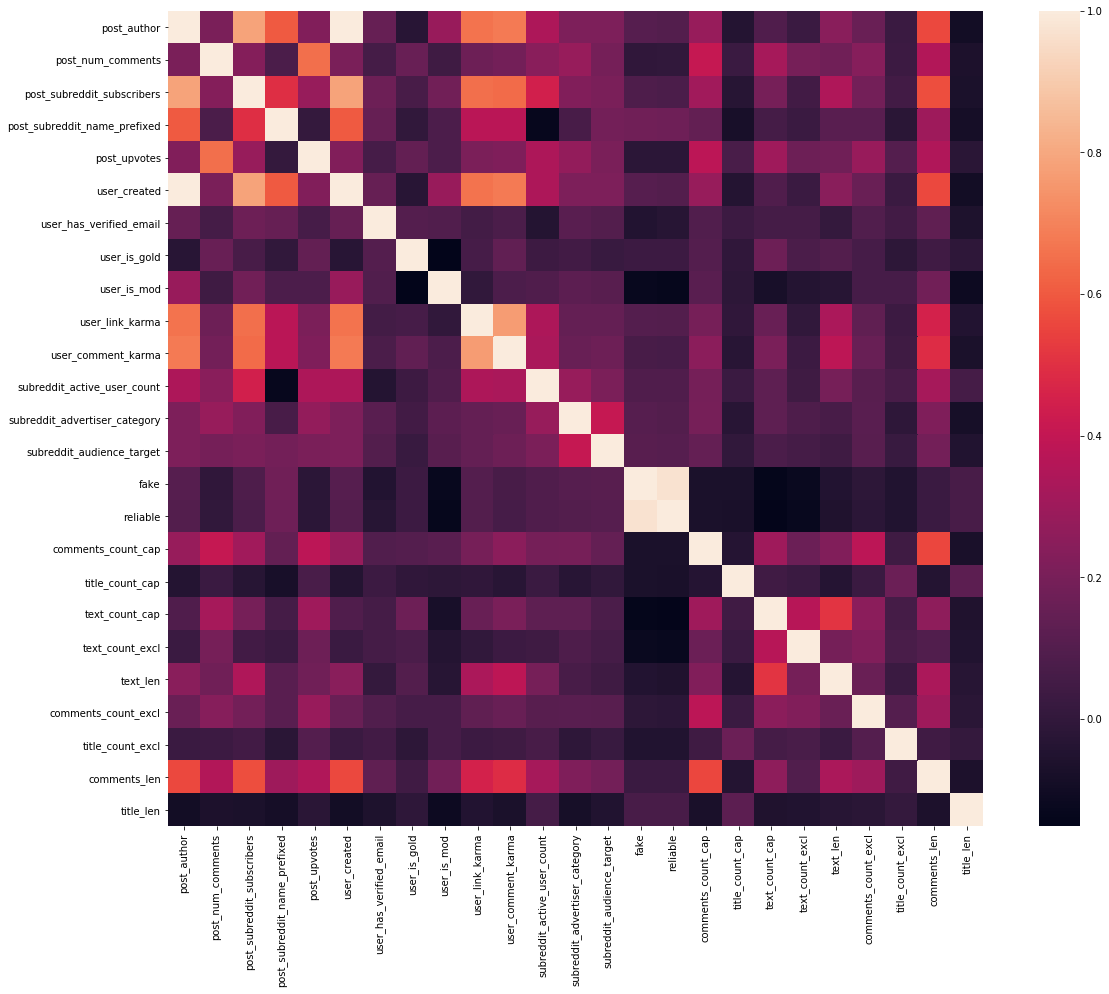

In [5]:
clean_data = data.drop(["post_title", "post_selftext", "comments", "post_id", "website", "doubt"], axis=1)
f, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(clean_data.apply(lambda x: x.factorize()[0]).corr(),square=True)

In [6]:
clean_data.describe()
clean_data.info()
clean_data.head()
print(len(clean_data[clean_data.fake == 1]))
print(len(clean_data[clean_data.reliable == 1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9894 entries, 0 to 9893
Data columns (total 25 columns):
post_author                      9894 non-null object
post_num_comments                9894 non-null int64
post_subreddit_subscribers       9894 non-null int64
post_subreddit_name_prefixed     9894 non-null object
post_upvotes                     9894 non-null int64
user_created                     9894 non-null float64
user_has_verified_email          9232 non-null object
user_is_gold                     9894 non-null bool
user_is_mod                      9894 non-null bool
user_link_karma                  9894 non-null int64
user_comment_karma               9894 non-null int64
subreddit_active_user_count      9894 non-null int64
subreddit_advertiser_category    2331 non-null object
subreddit_audience_target        3140 non-null object
fake                             9894 non-null int64
reliable                         9894 non-null int64
comments_count_cap               9894 no

In [7]:
data_4_model = clean_data
data_4_model = data_4_model.fillna(0)
data_4_model = data_4_model.drop(["post_author", "subreddit_audience_target", "subreddit_advertiser_category", "post_subreddit_name_prefixed"], axis=1)
cols_to_transform = ["user_has_verified_email"]
data_4_model = pandas.get_dummies(data=data_4_model, columns = cols_to_transform)
labels = ["fake", "reliable"]
features = [feature for feature in data_4_model.columns.values if feature not in labels]
print(data_4_model)

      post_num_comments  post_subreddit_subscribers  post_upvotes  \
0                     0                         506             1   
1                     2                     3748992             0   
2                    24                        8406             0   
3                    10                       25729             0   
4                     0                         506             1   
5                     0                         192             0   
6                     0                       11046             0   
7                   158                      745624           347   
8                     0                         506             1   
9                     5                    18970155             0   
10                    2                       32687             6   
11                    0                         506             1   
12                    0                         876             1   
13                    4           

In [8]:
print(features)
data_4_model.info()

['post_num_comments', 'post_subreddit_subscribers', 'post_upvotes', 'user_created', 'user_is_gold', 'user_is_mod', 'user_link_karma', 'user_comment_karma', 'subreddit_active_user_count', 'comments_count_cap', 'title_count_cap', 'text_count_cap', 'text_count_excl', 'text_len', 'comments_count_excl', 'title_count_excl', 'comments_len', 'title_len', 'user_has_verified_email_False', 'user_has_verified_email_True']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9894 entries, 0 to 9893
Data columns (total 22 columns):
post_num_comments                9894 non-null int64
post_subreddit_subscribers       9894 non-null int64
post_upvotes                     9894 non-null int64
user_created                     9894 non-null float64
user_is_gold                     9894 non-null bool
user_is_mod                      9894 non-null bool
user_link_karma                  9894 non-null int64
user_comment_karma               9894 non-null int64
subreddit_active_user_count      9894 non-null int64
fa

In [9]:
msk = np.random.rand(len(data_4_model)) < 0.8
train_data = data_4_model[msk]
test_data = data_4_model[~msk]

In [10]:
results = pandas.DataFrame(columns=["fake", "reliable"])

## Logistic Regression with network features 

Training cross validation mean accuracry for label fake 0.592955399698
             precision    recall  f1-score   support

          0       0.53      0.54      0.53       857
          1       0.66      0.65      0.65      1168

avg / total       0.60      0.60      0.60      2025

prob for testing set for fake [ 0.4474218   0.63239557  0.52891411 ...,  0.45810413  0.47937559
  0.45505916]


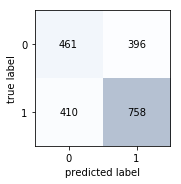

In [11]:
model = LogisticRegression()
rfe = RFE(model,11)
rfe = rfe.fit(data_4_model[features], data_4_model["fake"] )
final_features = []
for i in range(len(features)):
    if rfe.support_[i]:
        final_features.append(features[i]) 
kfold = model_selection.KFold(n_splits=20, random_state=7)
scores = model_selection.cross_val_score(model, train_data[final_features], train_data["fake"], cv=kfold)
print("Training cross validation mean accuracry for label fake", scores.mean())
model.fit(train_data[final_features], train_data["fake"])
print(metrics.classification_report(test_data["fake"], model.predict(test_data[final_features])))
print("prob for testing set for fake", model.predict_proba(test_data[final_features])[:, 1])
conf = metrics.confusion_matrix(test_data["fake"], model.predict(test_data[final_features]))
fig, ax = plot_confusion_matrix(conf_mat=conf)
plt.show()

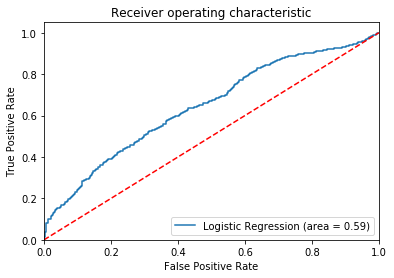

In [12]:
logit_roc_auc = roc_auc_score(test_data["fake"], model.predict(test_data[final_features]))
fpr, tpr, thresholds = roc_curve(test_data["fake"], model.predict_proba(test_data[final_features])[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

Let's work on NLP Part

In [13]:
data.head()

,post_id,website,post_author,post_title,post_num_comments,post_subreddit_subscribers,post_subreddit_name_prefixed,post_selftext,comments,post_upvotes,...,reliable,comments_count_cap,title_count_cap,text_count_cap,text_count_excl,text_len,comments_count_excl,title_count_excl,comments_len,title_len
0,4zmar5,trunews.com,removalbot,08-26 02:16 - 'Euro Banks Profits in Free Fall...,0,506,r/removalbot,[Euro Banks Profits in Free Fall Across All So...,[],1,...,0,0.0,9.0,10.0,0.0,265.0,0.0,0.0,2.0,172.0
1,m9isb,pakalertpress.com,timestoday,"The people must have a normal country, through...",2,3748992,r/politics,The media in the United States is one large wa...,"[""Tolerance and peace only lasts as long as ec...",0,...,0,3.0,1.0,45.0,1.0,2801.0,0.0,0.0,176.0,139.0
2,7g01mi,100percentfedup.com,bfwilley,Roy Moore witch hunt unravelling: More witness...,24,8406,r/AmericanPolitics,NaN,['**Sardonic_Samurai** too true when you want ...,0,...,0,45.0,9.0,NaN,NaN,NaN,2.0,1.0,1413.0,135.0
3,4i1bqo,musictimes.com,Poster_Nutsack,Musictimes.com article about ticket prices for...,10,25729,r/phish,NaN,['This article is garbage. Just because the li...,0,...,1,43.0,4.0,NaN,NaN,NaN,4.0,0.0,934.0,78.0
4,84jdi0,trunews.com,removalbot,03-15 03:03 - 'Musk Calls For Space Colonizati...,0,506,r/removalbot,[Musk Calls For Space Colonization as Failsafe...,[],1,...,0,0.0,9.0,11.0,0.0,293.0,0.0,0.0,2.0,158.0


In [14]:
msk = np.random.rand(len(data)) < 0.8
train = data[msk]
test = data[~msk]
TITLE = 'post_title'
COMMENT = 'post_selftext'
TEXT = "comments"

#Fill all missing values
train = train.fillna(0)
test = test.fillna(0)


#Transform comments array into a string
train[COMMENT] = train[COMMENT].apply(lambda ele: ''.join(str(ele)))
test[COMMENT] = test[COMMENT].apply(lambda ele: ''.join(str(ele)))


In [15]:
train.head()

,post_id,website,post_author,post_title,post_num_comments,post_subreddit_subscribers,post_subreddit_name_prefixed,post_selftext,comments,post_upvotes,...,reliable,comments_count_cap,title_count_cap,text_count_cap,text_count_excl,text_len,comments_count_excl,title_count_excl,comments_len,title_len
3,4i1bqo,musictimes.com,Poster_Nutsack,Musictimes.com article about ticket prices for...,10,25729,r/phish,0,['This article is garbage. Just because the li...,0,...,1,43.0,4.0,0.0,0.0,0.0,4.0,0.0,934.0,78.0
5,toqcr,pakalertpress.com,frontbot,9pm Tue 15 May 2012 - /r/conspiracy,0,192,r/frontconspiracy,1. [Iceland’s Amazing Peaceful Revolution – St...,[],0,...,0,0.0,2.0,318.0,2.0,9854.0,0.0,0.0,2.0,35.0
6,7g01cv,100percentfedup.com,bfwilley,Roy Moore witch hunt unravelling: More witness...,0,11046,r/USNEWS,0,[],0,...,0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,2.0,135.0
7,2tenwu,musictimes.com,joeylloyd,Bobby Shmurda Gun Charges Dismissed,158,745624,r/hiphopheads,http://www.musictimes.com/articles/25721/20150...,"['new bobby shmurda song - Bobby Snitch', 'gun...",347,...,1,48.0,5.0,0.0,0.0,126.0,4.0,0.0,2137.0,35.0
9,v8a1z,pakalertpress.com,Joseph_fritzl_316,So my friend keeps going on about how Gaddaffi...,5,18970155,r/AskReddit,He sent me this link as well which I'm skeptic...,"['Everybody is good and bad.', 'He kept securi...",0,...,0,6.0,4.0,14.0,0.0,530.0,0.0,0.0,283.0,161.0


## Tokenization and vectorization of the training text set (comments, title and text)

In [16]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [17]:
#Join 3 feature as a unique one
train["text"] = train[TITLE] + train[COMMENT] + train[TEXT]
test["text"] = test[TITLE] + test[COMMENT] + test[TEXT]

### Using a TF-IDF vectorizer for our model
* Will not give to much importance to current words

In [18]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)
trn_term_doc = vec.fit_transform(train["text"])
test_term_doc = vec.transform(test["text"])

### Implementing a basic Naive-Bayes classifier
* Help us to give more weight to a word based on the probability that this word belongs to a specific class

In [19]:
#Naive Bayes classifier
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

### Implementing our model as a logistic regression of a sparse matrix
* Use this model as a simple classification model for our fake news detection

In [20]:
x = trn_term_doc
test_x = test_term_doc

In [21]:
#Drop unecessary features from both dataset
train = train.drop(["post_title", "post_selftext", "comments", "post_id", "website", "doubt","post_author", "subreddit_audience_target", "subreddit_advertiser_category", "post_subreddit_name_prefixed", "text"], axis=1)
test = test.drop(["post_title", "post_selftext", "comments", "post_id", "website", "doubt","post_author", "subreddit_audience_target", "subreddit_advertiser_category", "post_subreddit_name_prefixed", "text"], axis=1)

### Fit and predict the model
* Check the classification report from our model
* Check the ROC curve and the AUC value of the current model

In [22]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(dual=True)
    #kfold = model_selection.KFold(n_splits=20, random_state=7)
    x_nb = x.multiply(r)
    train.score = x_nb
    #scores = model_selection.cross_val_score(model, x_nb, y, cv=kfold)
    return m.fit(x_nb, y), r

In [23]:
m,r = get_mdl(train["fake"])
print(metrics.classification_report(test["fake"], m.predict(test_x.multiply(r))))

/Users/antoinegargot/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


             precision    recall  f1-score   support

          0       0.89      0.79      0.84       869
          1       0.85      0.93      0.89      1144

avg / total       0.87      0.87      0.87      2013



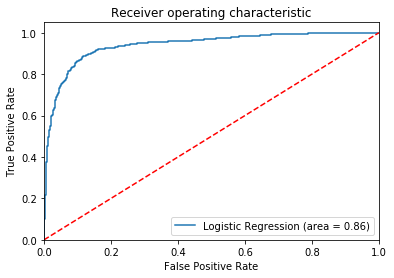

In [24]:
logit_roc_auc = roc_auc_score(test["fake"], m.predict(test_x.multiply(r)))
fpr, tpr, thresholds = roc_curve(test["fake"], m.predict_proba(test_x.multiply(r))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Merge dtm with network features

In [25]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(dual=True)
    #kfold = model_selection.KFold(n_splits=20, random_state=7)
    x_nb = x.multiply(r)
    train.score = x_nb
    #scores = model_selection.cross_val_score(model, x_nb, y, cv=kfold)
    features = train.values
    training_set = sparse.hstack((x_nb, features.astype(float)))
    return m.fit(training_set, y), r

In [26]:
m,r = get_mdl(train["fake"])
features = test.values
print(metrics.classification_report(test["fake"], m.predict(sparse.hstack((test_x.multiply(r), features.astype(float))))))

             precision    recall  f1-score   support

          0       0.49      0.61      0.55       869
          1       0.64      0.52      0.57      1144

avg / total       0.57      0.56      0.56      2013



/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


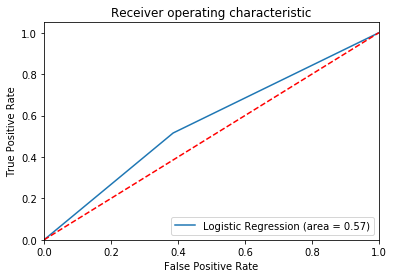

In [27]:
logit_roc_auc = roc_auc_score(test["fake"], m.predict(sparse.hstack((test_x.multiply(r), features.astype(float)))))
fpr, tpr, thresholds = roc_curve(test["fake"], m.predict_proba(sparse.hstack((test_x.multiply(r), features.astype(float))))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Fit and train our model by paritionning the training dataset
* Evaluate our model based on various portion of training dataset and fixed testing dataset

In [59]:
accuracies = []
recalls = []
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1)
    
for i in range(1, 11):
    prob = i / 10
    train_sample = train.sample(frac=prob, replace=True)
    train_term_doc = vec.fit_transform(train_sample["text"])
    test_term_doc = vec.transform(test["text"])
    model,r_coef = model_creation(train_sample["fake"], train_term_doc)
    accuracies.append(metrics.accuracy_score(test["fake"], model.predict(test_term_doc.multiply(r_coef))))
    recalls.append(metrics.recall_score(test["fake"], model.predict(test_term_doc.multiply(r_coef))))


/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


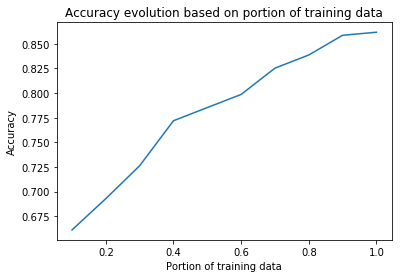

In [65]:
plt.figure()
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5 , 0.6, 0.7, 0.8, 0.9, 1],accuracies)
plt.xlabel('Portion of training data')
plt.ylabel('Accuracy')
plt.title('Accuracy evolution based on portion of training data')
plt.show()